## ETK Filtering

In [1]:
import Simulator
import Observation
import Statistics
import IEWParticleFilter

## Loading simulator 

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators

In [2]:
timestamp = "2021_08_26-12_22_18"

grid, simulator = Simulator.from_file(timestamp)

## Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [3]:
statistics = Statistics.Statistics(simulator, N_e=100, safe_history=True)

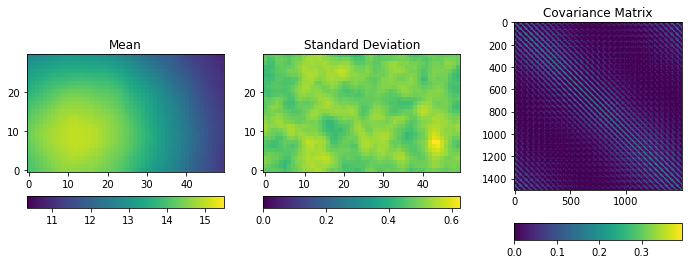

In [4]:
prior_args = Statistics.prior_args_from_file(timestamp)
statistics.set_prior(prior_args)

statistics.plot()

## Loading observations 

Observation positions which are fixed for a setup and values from the truth

In [5]:
obs_timestamp = "2021_08_26-12_22_28"
observation = Observation.from_file(grid, timestamp, obs_timestamp)

Remember to set observation positions and to set/observe values!


## IEWPF filtering

Updating/conditioning the distributions at every observation time

In [6]:
import numpy as np

ensemble_beforeDA = np.zeros((11,grid.N_x,statistics.ensemble.N_e))
ensemble_afterDA = np.zeros((11,grid.N_x,statistics.ensemble.N_e))

ensemble_beforeDA[0] = statistics.ensemble.ensemble
ensemble_afterDA[0] = statistics.ensemble.ensemble

0


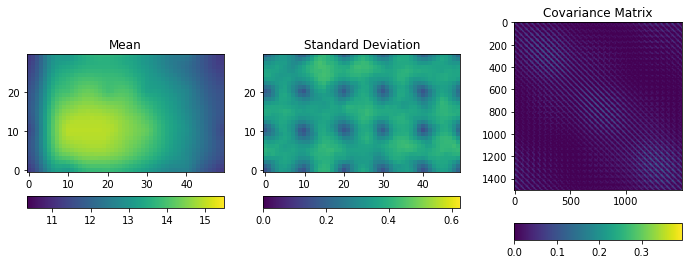

1


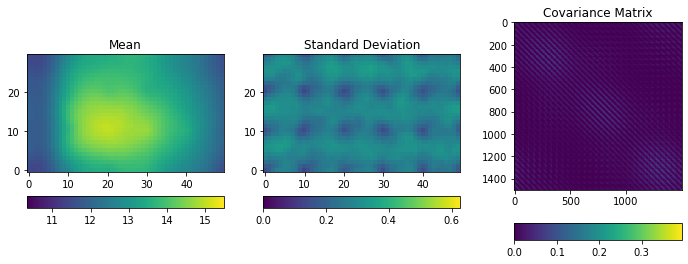

2


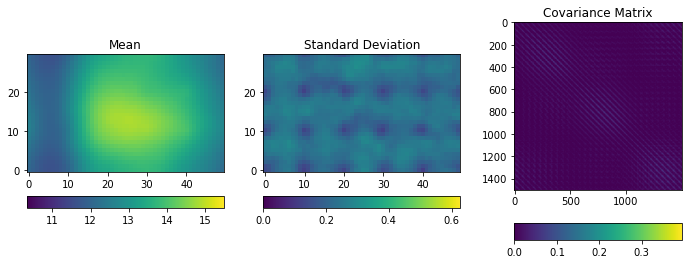

3


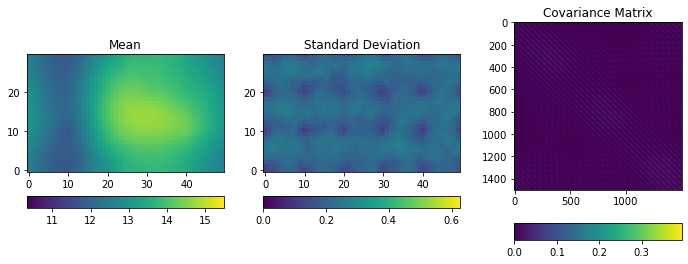

4


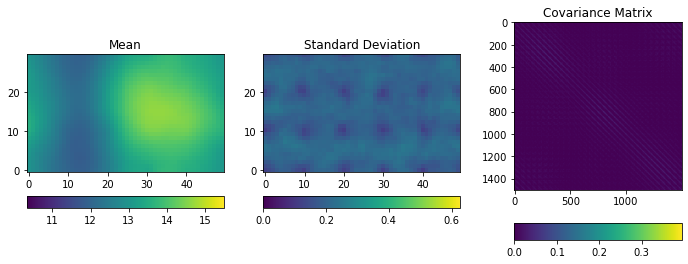

5


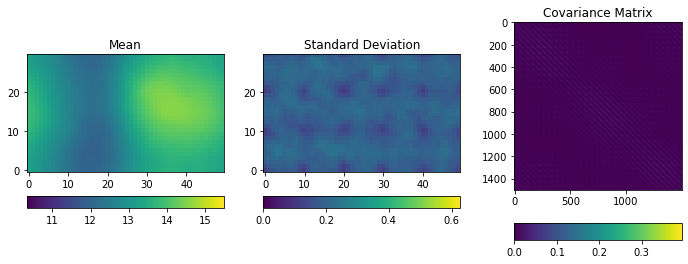

6


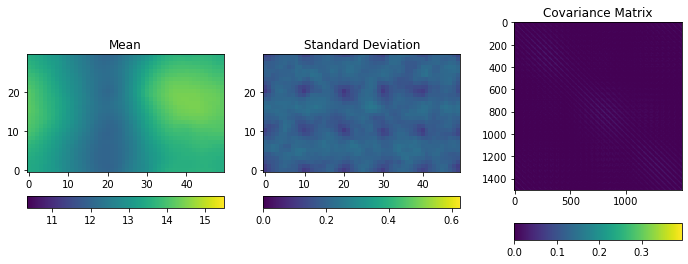

7


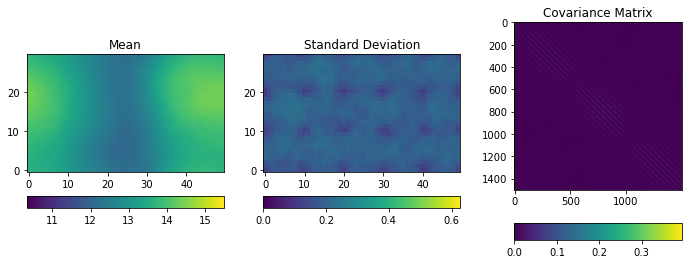

8


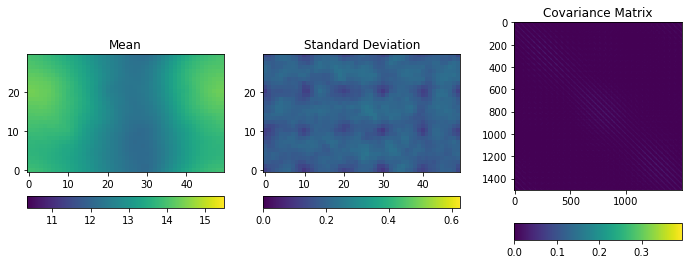

9


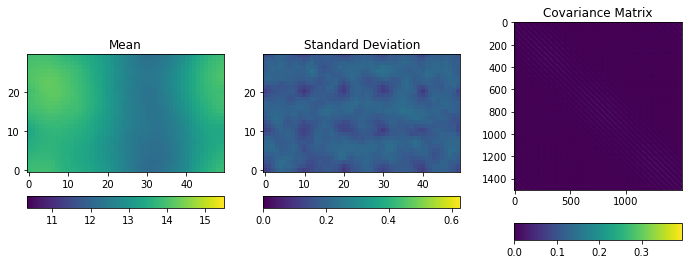

[0.8808982307794428, 0.9342704197542246, 0.9677319630739359, 0.977083424969103, 0.9814036876641359, 0.981813700122457, 0.9812579712109067, 0.9817694807243779, 0.9873821718855154, 0.9732410259433095]


In [7]:
iewpFilter = IEWParticleFilter.IEWParticle(statistics, observation)

for t in range(observation.N_obs):
    print(t)
    statistics.propagate(25, model_error=False)
    ensemble_beforeDA[t+1] = statistics.ensemble.ensemble
    iewpFilter.filter(statistics.ensemble.ensemble, observation.obses[t])
    ensemble_afterDA[t+1]  = statistics.ensemble.ensemble
    statistics.plot()

print(iewpFilter.betas)

## Correlation Study

In [8]:
points = [[20,10],[29,13]]

import numpy as np

indicator_field1 = np.zeros((grid.ny, grid.nx))
indicator_field1[points[0][1],points[0][0]] = 1.0
idx1 = np.where(indicator_field1.flatten() != 0 )[0][0]

indicator_field2 = np.zeros((grid.ny, grid.nx))
indicator_field2[points[1][1],points[1][0]] = 1.0
idx2 = np.where(indicator_field2.flatten() != 0 )[0][0]

In [9]:
mean_point1 = statistics.prev_mean[idx1]
mean_point2 = statistics.forecast_mean[idx2]

stddev_point1 = statistics.prev_stddev[idx1]
stddev_point2 = statistics.forecast_stddev[idx2]

cov_point2point = 1/(statistics.ensemble.N_e-1) * (statistics.prev_ensemble.ensemble[idx1] - mean_point1) @ (statistics.forecast_ensemble.ensemble[idx2] - mean_point2)

corr_point2point = cov_point2point/(stddev_point1*stddev_point2)
corr_point2point

0.2932865836624569